In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#!pip install torch==1.0.1 torchvision==0.2.2

After setting up the Colab notebook on Google free GPU, now we can get started with our project. First, we import all the required package:

In [ ]:
###import packages for project

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import PIL
import scipy.ndimage as nd

The more data, the better the model will learn. Hence, apply some data augmentation to generate different variations of the original data to increase the sample size for training, validation and testing process. This augmentation can be performed by defining a set of transforming functions in the torchvision module. The detailed codes are as following:

In [ ]:
## data augmentation with torchvision.transforms

transformers = {'train_transforms' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
]),
'test_transforms' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
]),
'valid_transforms' : transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])}

In [ ]:
trans = ['train_transforms','valid_transforms','test_transforms']

After defining the transformers, now we can use torchvision.datasets.ImageFolder module we load images from our dataset directory and apply the predefined transformers on them as following:

In [ ]:
path = "/content/drive/My Drive/FB-Ai-Hackathon/pneumonia-pytorch-localization/chest_xray/"
#path = "/content/drive/My Drive/FB-Ai-Hackathon/pneumonia-pytorch-localization/Data/"
categories = ['train','val','test']
dset = {x : torchvision.datasets.ImageFolder(path+x, transform=transformers[y]) for x,y in zip(categories, trans)}

After refreshing your memory on the basics, we can start with this project using the COVID chest X-ray data. First, we need to initialize our model class by calling the nn.Module, which create a graph-like structure of our network. In particularly, as we mentioned earlier, the pretrained model of Resnet152 was used in our training process. This transfer learning give us a big advantage in retraining on Hence, we need to define our ResNet-152 in the init of nn.Module for transfer learning. Then after define the init function, we need to create a forward function as part of the requirement for Pytorch.

In [ ]:
dataset_sizes = {x : len(dset[x]) for x in categories}

In [ ]:
for x in categories:
  print('{}: {}'.format(x,dataset_sizes[x]))

train: 2624
val: 228
test: 228


In [ ]:
num_threads = 0
dataloaders =  {x : torch.utils.data.DataLoader(dset[x], batch_size=16, shuffle=True, num_workers=num_threads)
               for x in categories} 

After refreshing your memory on the basics, we can start with this project using the COVID-19 & Pneumonia chest X-ray data. First, we need to initialize our model class by calling the nn.Module, which create a graph-like structure of our network. In particularly, as we mentioned earlier, the pretrained model of Resnet152 was used in our training process. This transfer learning give us a big advantage in retraining on Hence, we need to define our ResNet-152 in the init of nn.Module for transfer learning. Then after define the init function, we need to create a forward function as part of the requirement for Pytorch.

In [ ]:
##Build model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = torchvision.models.resnet152(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Linear(self.model.fc.in_features,2),
            nn.LogSoftmax(dim=1)
        )
        for params in self.model.parameters():
            params.requires_grad = False
        self.model.fc = self.classifier
        
    def forward(self, x):
        return self.model(x)
    
    def fit(self, dataloaders, num_epochs):
        train_on_gpu = torch.cuda.is_available()
        optimizer = optim.Adam(self.model.fc.parameters())
        scheduler = optim.lr_scheduler.StepLR(optimizer, 4)
        criterion = nn.NLLLoss()
        since = time.time()
        
        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc =0.0
        if train_on_gpu:
            self.model = self.model.cuda()
        for epoch in range(1, num_epochs+1):
            print("epoch {}/{}".format(epoch, num_epochs))
            print("-" * 10)
            
            for phase in ['train','test']:
                if phase == 'train':
                    scheduler.step()
                    self.model.train()
                else:
                    self.model.eval()
                
                running_loss = 0.0
                running_corrects = 0.0
                
                for inputs, labels in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    optimizer.zero_grad()
                    
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print("{} loss:  {:.4f}  acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
                
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
        
        time_elapsed = time.time() - since
        print('time completed: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 600))
        print("best val acc: {:.4f}".format(best_acc))
        
        self.model.load_state_dict(best_model_wts)
        return self.model

In [ ]:
# Calling the model and fit on training data:
model = Model()
model_ft = model.fit(dataloaders,1)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


In [ ]:
# Save the trained model
torch.save(model.state_dict(), "/content/drive/My Drive/FB-Ai-Hackathon/pneumonia-pytorch-localization/Best_weights/best_covid_model.pth")

When we want to load this trained weights back to the model for prediction on new data, we just need to follow these lines of code:

In [ ]:
# Loading the saved model for prediction
state_dict = torch.load("/content/drive/My Drive/FB-Ai-Hackathon/pneumonia-pytorch-localization/Best_weights/best_pnemonia_model.pth")
model.load_state_dict(state_dict, strict=False)
model_ft = model.model
model_ft = model_ft.eval()

In [ ]:
loader = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                            transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
def image_loader(image_name):
    image = PIL.Image.open(image_name).convert("RGB")
    image = loader(image).float()
    image = image.unsqueeze(0)
    return image

After training on the data, we can now test the performance of our model using the accuracy metrics. Let's see what is the accuracy of our model on the training set:

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    model.train()

check_accuracy(dataloaders['train'], model)

Got 2593 / 2624 with accuracy 98.82


In [ ]:
check_accuracy(dataloaders['test'], model)

For activation map, we can use the register_forward_hook module to obtain activation of the last convolutional layer as described above, we use the register_forward_hook module. The code is as following:

In [ ]:
class LayerActivations():
    features=[]
    def __init__(self, model):
        self.hooks = []
        self.hooks.append(model.layer4.register_forward_hook(self.hook_fn))
    def hook_fn(self,module,input,output):
        self.features.append(output)
    def remove(self):
        for hook in self.hooks:
            hook.remove()

After defining the LayerActivation module, we can use this module to visualize the predicted output on testing set. Hence, for convinience, we define a function called predict_img so we can use this predict and automatically visualize the Activation Map on each images later. The function is defined as following:

In [ ]:
def predict_img(path, model_ft):
  image_path = path
  img = image_loader(image_path)
  acts = LayerActivations(model_ft)
  img = img.cpu()
  logps = model_ft(img)
  ps = torch.exp(logps) 
  out_features = acts.features[0]
  out_features = torch.squeeze(out_features, dim=0)
  out_features = np.transpose(out_features.cpu(),axes=(1,2,0))
  W = model_ft.fc[0].weight
  top_probs, top_classes = torch.topk(ps, k=2)
  pred = np.argmax(ps.detach().cpu())
  w = W[pred,:]
  cam = np.dot(out_features.cpu(), w.detach().cpu())
  class_activation = nd.zoom(cam, zoom=(32,32),order=1)
  img = img.cpu()
  img = torch.squeeze(img,0)
  img = np.transpose(img,(1,2,0))
  mean = np.array([0.5,0.5,0.5])
  std =  np.array([0.5,0.5,0.5])
  img = img.numpy()
  img = (img + mean) * std
  img = np.clip(img, a_max=1, a_min=0)
  return img, class_activation, pred

In [ ]:
test_dir='/content/drive/My Drive/FB-Ai-Hackathon/pneumonia-pytorch-localization/Data_sample/'
from skimage.io import imread
from PIL import Image
import glob
image_list = []
for filename in glob.glob(test_dir+'/*.jpeg'): 
    #im=Image.open(filename)
    image_list.append(filename)

Checking if the testing set are loaded correctly

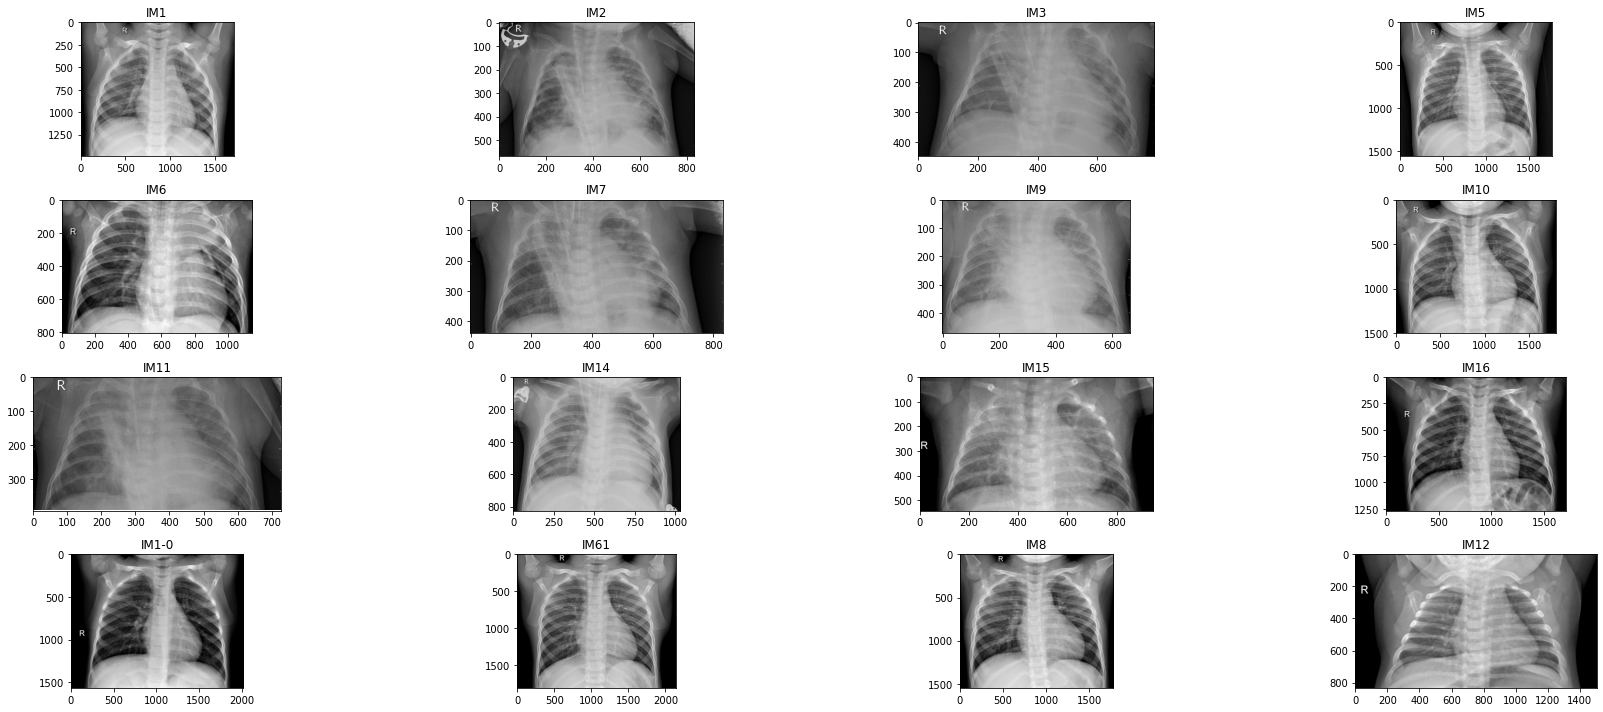

In [ ]:
f, ax = plt.subplots(4,4, figsize=(30,10))

def plot_input(image_list):
  for i in range(len(image_list)):
      img = imread(image_list[i])
      name = image_list[i].split("/")
      name = name[len(name)-1].split(".")[0]
      ax[i//4, i%4].imshow(img, cmap='gray')
      ax[i//4, i%4].set_title(name)
      plt.tight_layout()
  plt.show()
plot_input(image_list)

Now, let's load the testing data folder and use this newly defined predict_img function to visualize all the testing images (with both prediction class and Activation map). The snipet of that code is as following:

0


tensor(0)

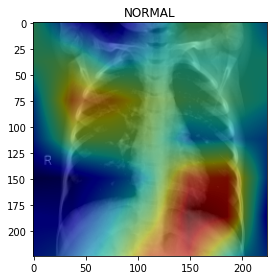

In [ ]:
def predict_image(image, model_ft):
  img, class_activation, pred = predict_img(image, model_ft)
  print(pred.item())
  name = image.split("/")
  name = name[len(name)-1].split(".")[0]
  img = Image.fromarray((img * 255).astype(np.uint8))
  plt.ioff()
  plt.imshow(class_activation, cmap='jet',alpha=1)
  plt.imshow(img, alpha=0.55)
  plt.title(dset['test'].classes[pred])
  plt.tight_layout()

  # plt.show()
  return pred

predict_image(image_list[12], model_ft)

1


tensor(1)

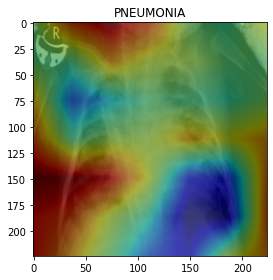

In [ ]:
predict_image(image_list[1], model_ft)

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.0f' #if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

As you can see, the final results look really nice. This activation map is super informative for the radiologists to quickly pinpoint the area of infection on chest X-ray. To make our project more user-friendly. the final step is web-app development with an interactive UI. From our training the model, the best model was saved in a .pthf file extension. The trained weights and architecture from this .pth file are then deployed in a form of Django backend web app CovidScan.ai. While the minimal front-end of this web app is done using HTML, CSS, Jquery, Bootstrap. In our latter stage, the web-app will then be deployed and hosted on a Debian server.